# Import library

In [276]:
import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score 
import pickle
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor


# Load data

In [277]:
df = pd.read_csv('../data/data.csv')
backup = copy.deepcopy(df)

# Data overview

In [278]:
def describle_data():
    print('Shape of data:\n', df.shape)
    print('--'*20)
    print('Columns of data: \n', df.columns)
    print('--'*20)
    print('Data types of data: \n', df.dtypes)
    print('--'*20)
    print('Missing values of data: \n', df.isna().sum())
    print('--'*20)
    print('Describe data: \n', df.describe())
    print('--'*20)
    print('Info data: \n', df.info())
describle_data()

Shape of data:
 (26956, 11)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year               object
price              object
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          38
year              11
price             11
assemble_place    11
series            11
driven kms        11
num_of_door       11
num_of_seat       11
engine_type       11
transmission      11
url               11
dtype: int64
----------------------------------------
Describe data: 
     

# Xóa bỏ những xe bị trùng lặp

In [279]:
df.drop_duplicates(subset=['url'], inplace=True)
describle_data()

Shape of data:
 (25157, 11)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year               object
price              object
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          35
year               1
price              1
assemble_place     1
series             1
driven kms         1
num_of_door        1
num_of_seat        1
engine_type        1
transmission       1
url                1
dtype: int64
----------------------------------------
Describe data: 
     

# Chuyển đổi kiểu dữ liệu cho các cột year, price sang kiểu số thực để có thể thực hiện các phép tính toán

Year

In [280]:
def process_year_colum(year):
    if year.isdigit():
        return float(year)
    else:
        return -1
df['year'] = df['year'].astype(str).apply(process_year_colum)
describle_data()

Shape of data:
 (25157, 11)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year              float64
price              object
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          35
year               0
price              1
assemble_place     1
series             1
driven kms         1
num_of_door        1
num_of_seat        1
engine_type        1
transmission       1
url                1
dtype: int64
----------------------------------------
Describe data: 
     

Chuyển đổi giá từ dạng triệu/tỷ về dạng số

In [281]:
def process_price(price):
    try:
        if price.find('Tỷ') != -1:
            ty= price.split('Tỷ')[0]
            trieu = price.split('Tỷ')[1]
            trieu = trieu.split('Triệu')[0]
            return float(ty)*1000000000 + float(trieu)*1000000
        elif price.find('Triệu') != -1:
            trieu = price.split('Triệu')[0]
            trieu = trieu.replace(' ','')
            return float(trieu)*1000000
        else:
            return 0
    except:
        return 0
df['price'] = df['price'].astype(str).apply(process_price)

In [282]:
# xóa các xe có giá trị km <= 0
df = df[df['driven kms'] > 0]

In [283]:
df['price'].describe()


count    2.515600e+04
mean     1.064326e+09
std      1.664726e+09
min      0.000000e+00
25%      3.850000e+08
50%      5.600000e+08
75%      9.450000e+08
max      3.860000e+10
Name: price, dtype: float64

# Xử lý các cột dạng nhãn

Car_name có hai phần là hãng xe và tên xe, ta sẽ tách ra thành hai cột là brand và model


In [284]:
df['brand'] = df['car_name'].str.split().str[0]
df['model'] = df['car_name'].str.split().str[1:].str.join(' ')

In [285]:
df['brand'].value_counts()

brand
Toyota        4798
Mercedes      2933
Hyundai       2832
Kia           2681
Ford          2236
              ... 
Howo             1
Samsung          1
Scion            1
SHUGUANG         1
Brilliance       1
Name: count, Length: 85, dtype: int64

In [286]:
df['model']=df['model'].str.split(' ').str.slice(0,3).str.join(' ')

In [287]:
# các model có số lượng dưới 10 xe sẽ được gộp vào thành model Other
model_counts = df['model'].value_counts()
model_counts[model_counts < 5]
model_counts[model_counts < 5].index
df['model'] = df['model'].replace(model_counts[model_counts < 5].index, 'Other')

In [288]:
df['model']

0          Range Rover HSE
1        Outlander 2.0 CVT
2            3 1.5L Luxury
3                 2 1.5 AT
4            Swift GLX 1.2
               ...        
26898        Swift GLX 1.2
26899        i10 Grand 1.2
26900         Rush 1.5S AT
26901               GX 460
26902    Fortuner 2.4G 4x2
Name: model, Length: 25156, dtype: object

In [289]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,url,brand,model
0,LandRover Range Rover HSE 3.0,2015.0,2.700000e+09,Nhập khẩu,SUV,65000.0,5.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-landrover-range_rover-h...,LandRover,Range Rover HSE
1,Mitsubishi Outlander 2.0 CVT Premium,2018.0,6.660000e+08,Lắp ráp trong nước,SUV,50000.0,5.0,7.0,Xăng,Số tự động,https://bonbanh.com/xe-mitsubishi-outlander-2....,Mitsubishi,Outlander 2.0 CVT
2,Mazda 3 1.5L Luxury,2019.0,4.900000e+08,Lắp ráp trong nước,Sedan,51000.0,4.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-mazda-3-1.5l-luxury-201...,Mazda,3 1.5L Luxury
3,Mazda 2 1.5 AT,2015.0,3.650000e+08,Lắp ráp trong nước,Sedan,38000.0,4.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-mazda-2-1.5-at-2015-491...,Mazda,2 1.5 AT
4,Suzuki Swift GLX 1.2 AT,2021.0,5.650000e+08,Nhập khẩu,Hatchback,6000.0,5.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-suzuki-swift-glx-1.2-at...,Suzuki,Swift GLX 1.2


# Xử lý các dữ liệu bị thiếu hoặc sai


Xử lý cột year

In [290]:
car_before_1990 = df[df['year'] < 1990]
print('Number of car before 1990: ', car_before_1990.shape[0])
print('Number of car before 1990: ', car_before_1990['year'].value_counts())

Number of car before 1990:  238
Number of car before 1990:  year
-1.0      236
 200.0      1
 700.0      1
Name: count, dtype: int64


Xóa các dòng năm sản xuất không hợp lệ < 1900

In [291]:
df = df[df['year'] > 1990]
describle_data()

Shape of data:
 (24893, 13)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url',
       'brand', 'model'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year              float64
price             float64
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
brand              object
model              object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          0
year              0
price             0
assemble_place    0
series            0
driven kms        0
num_of_door       0
num_of_seat       0
engine_type       0
transmission      0
url               0
brand    

Cột price: xóa các giá trị <= 0

In [292]:
df = df[df['price'] > 0]
describle_data()

Shape of data:
 (24814, 13)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url',
       'brand', 'model'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year              float64
price             float64
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
brand              object
model              object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          0
year              0
price             0
assemble_place    0
series            0
driven kms        0
num_of_door       0
num_of_seat       0
engine_type       0
transmission      0
url               0
brand    

Cột num_of_door
Thông thường các xe có tối đa 5 - 6 cửa, với những giá trị sai ta sẽ điền bằng giá trị xuất hiện nhiều nhất trong cột num_of_door

In [293]:
df['num_of_door'] = df['num_of_door'].apply(lambda x: df['num_of_door'].value_counts().index[0] if x > 6 else x)

Cột brand

In [294]:
df['brand'].value_counts()

brand
Toyota        4775
Mercedes      2906
Hyundai       2827
Kia           2640
Ford          2230
              ... 
Howo             1
Samsung          1
Aston            1
Scion            1
Brilliance       1
Name: count, Length: 83, dtype: int64

Cột brand có một số hãng có số lượng xe rất ít hoặc bị thiếu, ta sẽ gộp các hãng xe này thành một nhóm là 'other'
Nếu số xe của hãng đó nhỏ hơn 10 thì sẽ gộp vào nhóm 'Other'

In [295]:
threshold = 5
car_count = df['brand'].value_counts()
small_brands = car_count[car_count < threshold].index.tolist()
df['brand'] = df['brand'].apply(lambda x: 'Other' if x in small_brands else x)
df['brand'].fillna('Other', inplace=True)

In [296]:
# in ra tất cả brand
# sắp xếp theo thứ tự giảm dần về giá trung bình
print(df.groupby('brand')['price'].mean().sort_values(ascending=False))


brand
Lamborghini    1.454000e+10
Rolls          1.378962e+10
Bentley        1.066070e+10
McLaren        9.620000e+09
Lincoln        6.090806e+09
LandRover      4.203340e+09
Porsche        4.017987e+09
Maserati       3.554455e+09
Lexus          3.278581e+09
Jeep           2.971826e+09
Cadillac       2.515273e+09
Volvo          2.218634e+09
Mercedes       2.004621e+09
Jaguar         1.798727e+09
Infiniti       1.742200e+09
Mini           1.427632e+09
BMW            1.415890e+09
Audi           1.258419e+09
Other          1.091310e+09
Subaru         9.207143e+08
Volkswagen     8.474800e+08
Peugeot        8.188621e+08
Toyota         7.597510e+08
Ford           6.421570e+08
VinFast        5.650631e+08
Mazda          5.529249e+08
Hyundai        5.382045e+08
Honda          5.294520e+08
Baic           5.210000e+08
MG             5.098780e+08
Mitsubishi     5.069020e+08
Kia            4.845394e+08
Nissan         4.504627e+08
Isuzu          4.026667e+08
Suzuki         3.871135e+08
Chevrolet     

In [297]:
# def car_band(x):
#     if x in ['Land', 'Lamborghini', 'Jaguar', 'BMW', 'Mercedes', 'Porsche','Jeep',
#        'Audi', 'Bentley','Mini','LandRover','Lexus','Maserati','Rolls','Ferrari','Aston','Lincoln','Maserati','Cadillac']:
#         return 'HIGH END CAR'    
#     elif x in ['Ford',
#             'Skoda',
#          'Mahindra',
#             'Force',
#        'Mitsubishi',
#            'Toyota',
#             'ISUZU',
#            'Volvo',
#           'Isuzu','Other']:
#         return 'MIDDLE RANGE CAR'
#     else:
#         return 'LOW END CAR'
# df['brand']=df['brand'].apply(car_band)
def car_band(x):
    if x in ['Rolls', 'Bentley', 'Ferrari','Lincoln','Porsche','LandRover','Lexus','Jeep','Lamborghini','McLaren','Maserati',]:
        return 'LUXURY CAR'
    elif x in ['Cadillac', 'Mercedes', 'Audi', 'BMW', 'Volvo','Jaguar','Infiniti','Mini','BMW']:
        return 'PREMIUM CAR'
    elif x in ['Subaru', 'Mitsubishi', 'Ford', 'Kia','VinFast','Mazda','Honda','Hyundai','Kia','Baic','Toyota','Mazda','Renault','Other','Volkswagen','Peugeot',]:
        return 'VOLUME CAR'
    else:
        return 'LOW-PRICE CAR'
# # def car_band(x):
# #     if x in ['Rolls', 'Bentley', 'Lincoln', 'Land Rover', 'Porsche', 'Maserati', 'Lexus', 'Jeep', 'Cadillac']:
# #         return 'LUXURY CAR'
# #     elif x in ['Mini', 'BMW', 'Audi', 'Volvo', 'Mercedes-Benz', 'Infiniti', 'Jaguar','Other']:
# #         return 'PREMIUM CAR'
# #     elif x in ['Subaru', 'Volkswagen', 'Peugeot', 'Toyota', 'Ford', 'VinFast', 'Mazda', 'Hyundai', 'Honda']:
# #         return 'VOLUME CAR'
# #     else:
# #         return 'LOW-PRICE CAR'
# # def car_band(x):
# #     if x in ['Rolls', 'Bentley', 'Lincoln', 'LandRover', 'Porsche', 'Maserati', 'Lexus', 'Jeep', 'Cadillac']:
# #         return 'LUXURY'
# #     elif x in ['Other', 'Volvo', 'Mercedes', 'Infiniti', 'Jaguar', 'Mini', 'BMW', 'Audi']:
# #         return 'PREMIUM'
# #     elif x in ['Subaru', 'Volkswagen', 'Peugeot', 'Toyota', 'Ford', 'VinFast', 'Mazda', 'Hyundai', 'Honda','MG','Mitsubishi']:
# #         return 'VOLUME'
# #     else:
# #         return 'LOWEND'

# df['brand_segment'] = df['brand'].apply(car_band)
# df.drop(columns=['brand'], inplace=True)
# df['brand_segment'].value_counts()


In [298]:
df.isna().sum()

car_name          0
year              0
price             0
assemble_place    0
series            0
driven kms        0
num_of_door       0
num_of_seat       0
engine_type       0
transmission      0
url               0
brand             0
model             0
dtype: int64

# Trực quan hóa dữ liệu

Tìm hiểu về mối liên hệ giữa giá xe và các thuộc tính khác

In [299]:
#vẽ price theo brand, series,year
# plt.figure(figsize=(20, 10))
# sns.barplot(x='brand_segment', y='price', data=df)
# plt.title('Price by brand')
# plt.xticks(rotation=90)
# plt.show()

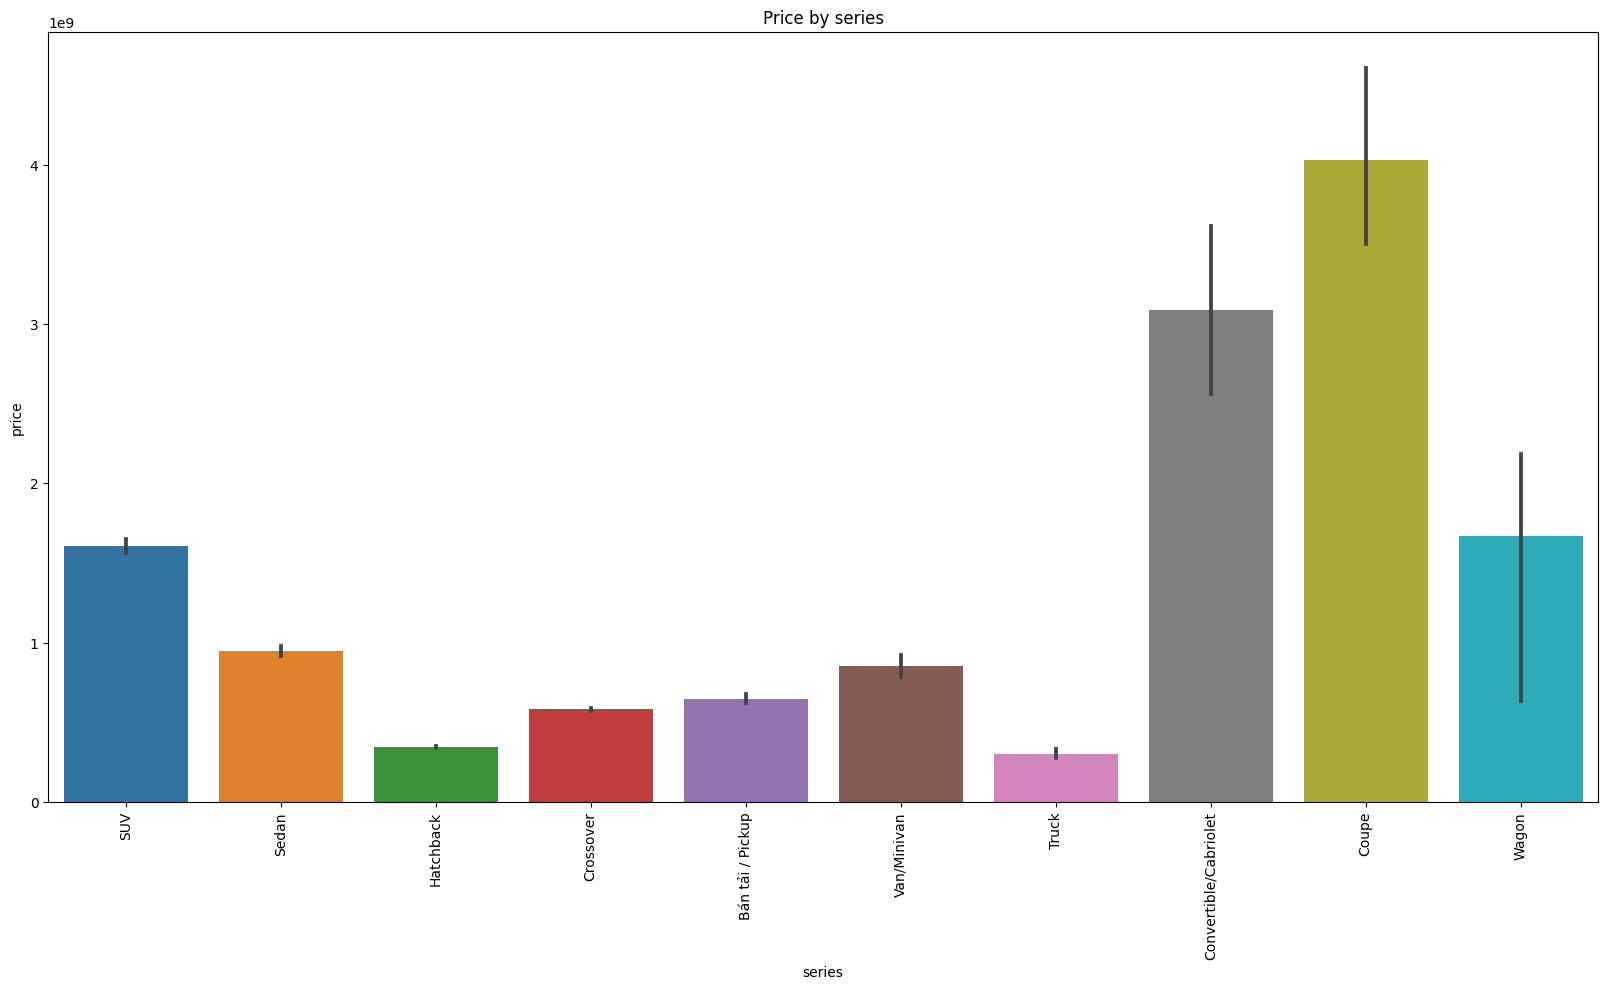

In [300]:
plt.figure(figsize=(20, 10))
sns.barplot(x='series', y='price', data=df)
plt.title('Price by series')
plt.xticks(rotation=90)
plt.show()

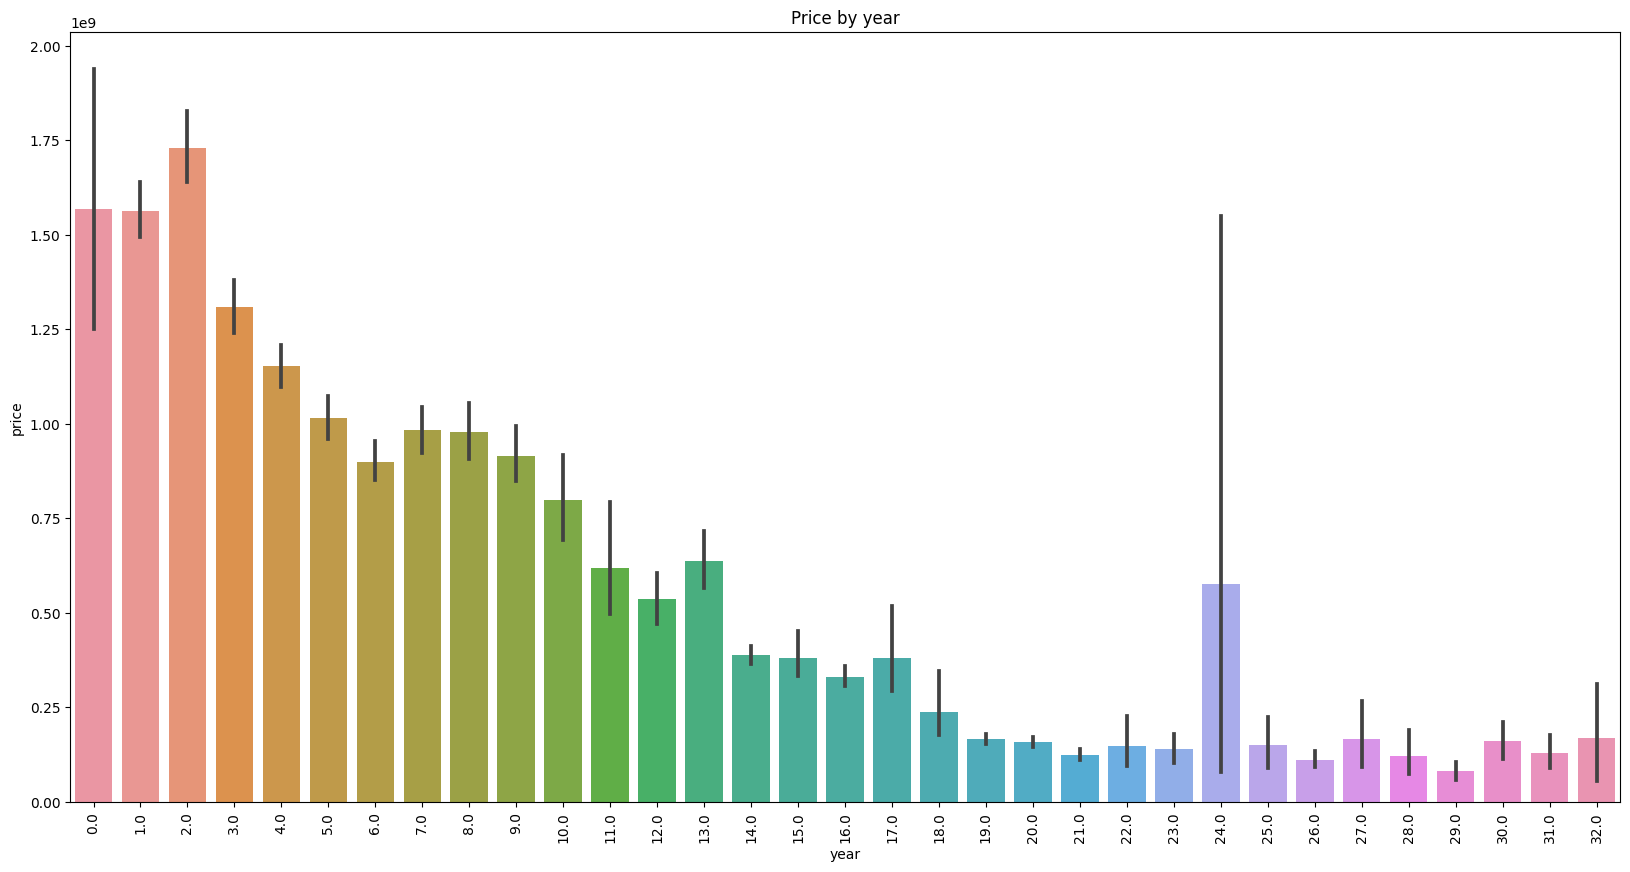

In [301]:
plt.figure(figsize=(20, 10))
#đổi năm sản xuất thành tuổi xe
df['year'] = 2023 - df['year']
sns.barplot(x='year', y='price', data=df)
plt.title('Price by year')
plt.xticks(rotation=90)
plt.show()

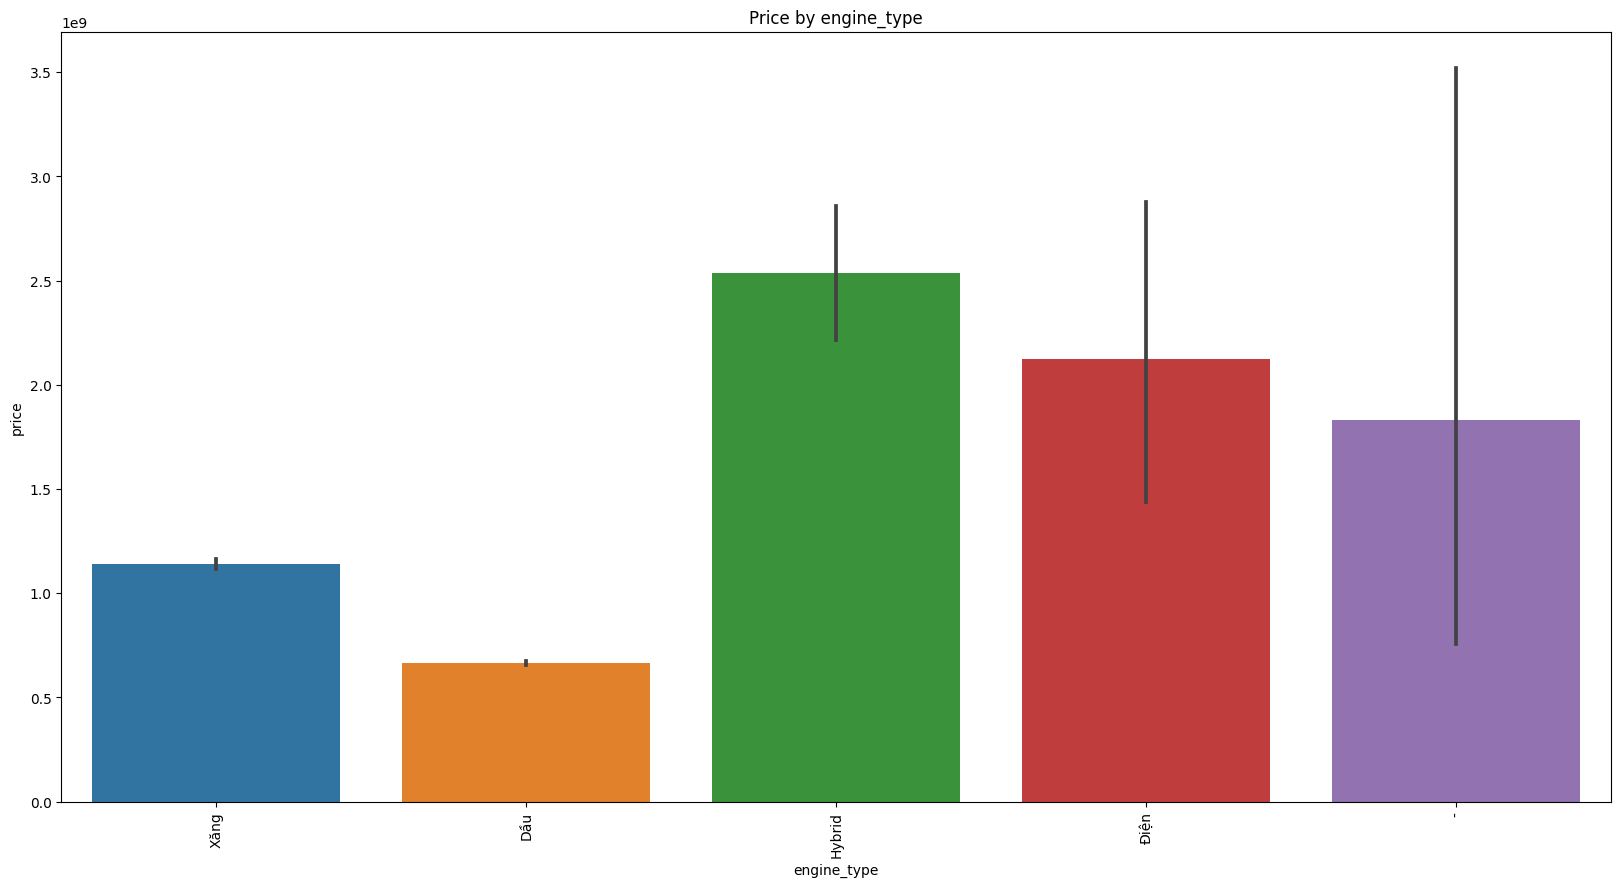

In [302]:
plt.figure(figsize=(20, 10))
sns.barplot(x='engine_type', y='price', data=df)
plt.title('Price by engine_type')
plt.xticks(rotation=90)
plt.show()


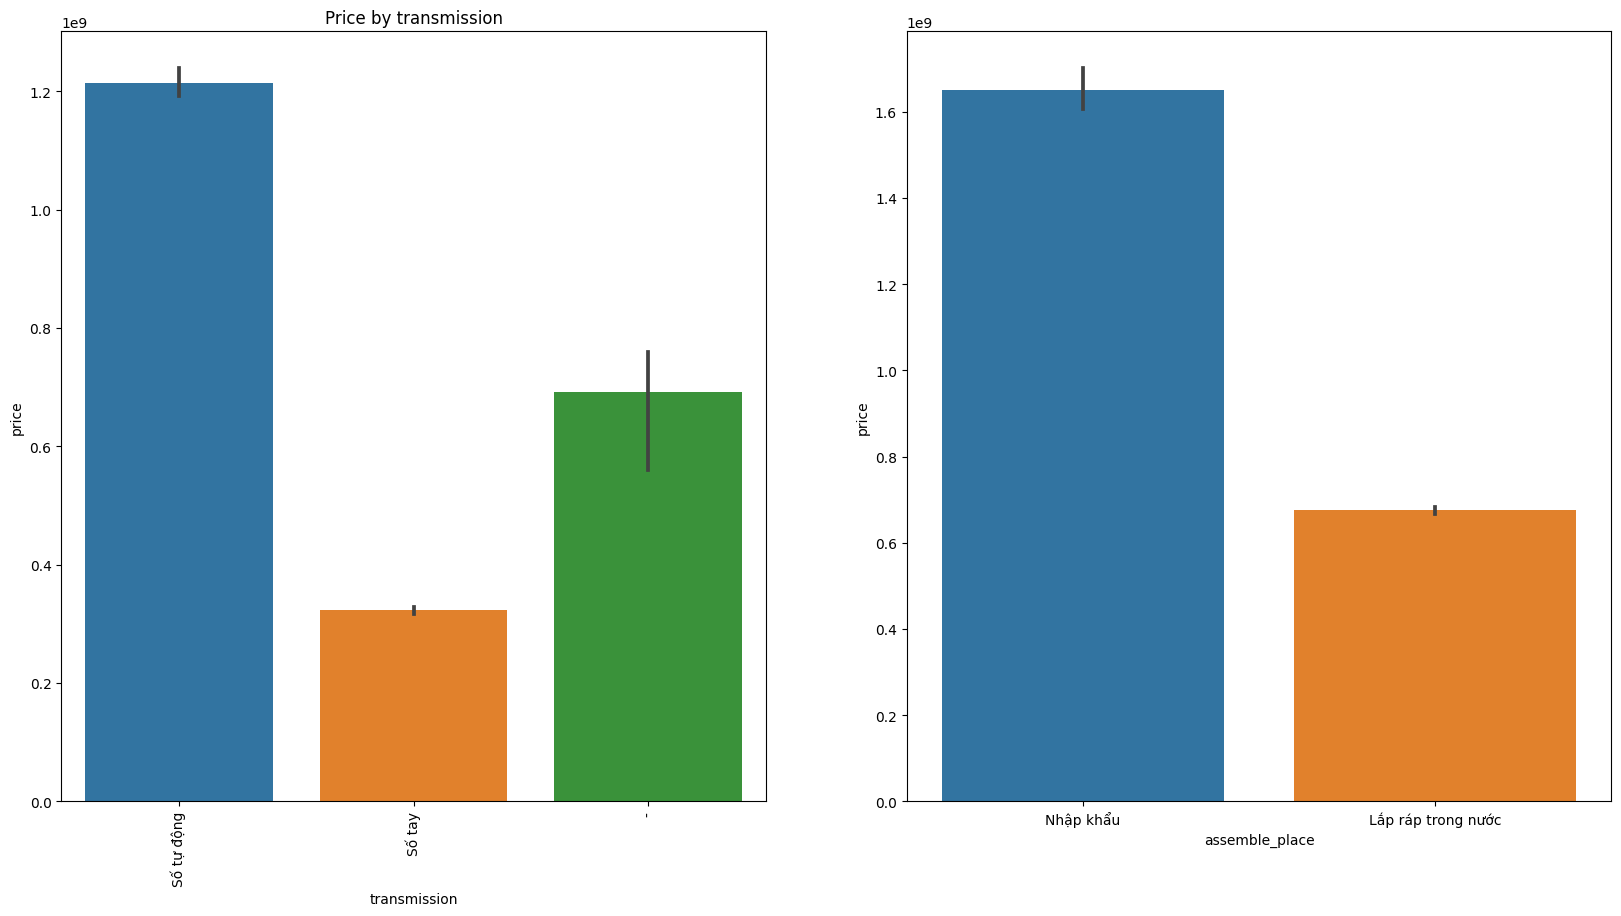

In [303]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.barplot(x='transmission', y='price', data=df)
plt.title('Price by transmission')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.barplot(x='assemble_place', y='price', data=df)
plt.show()

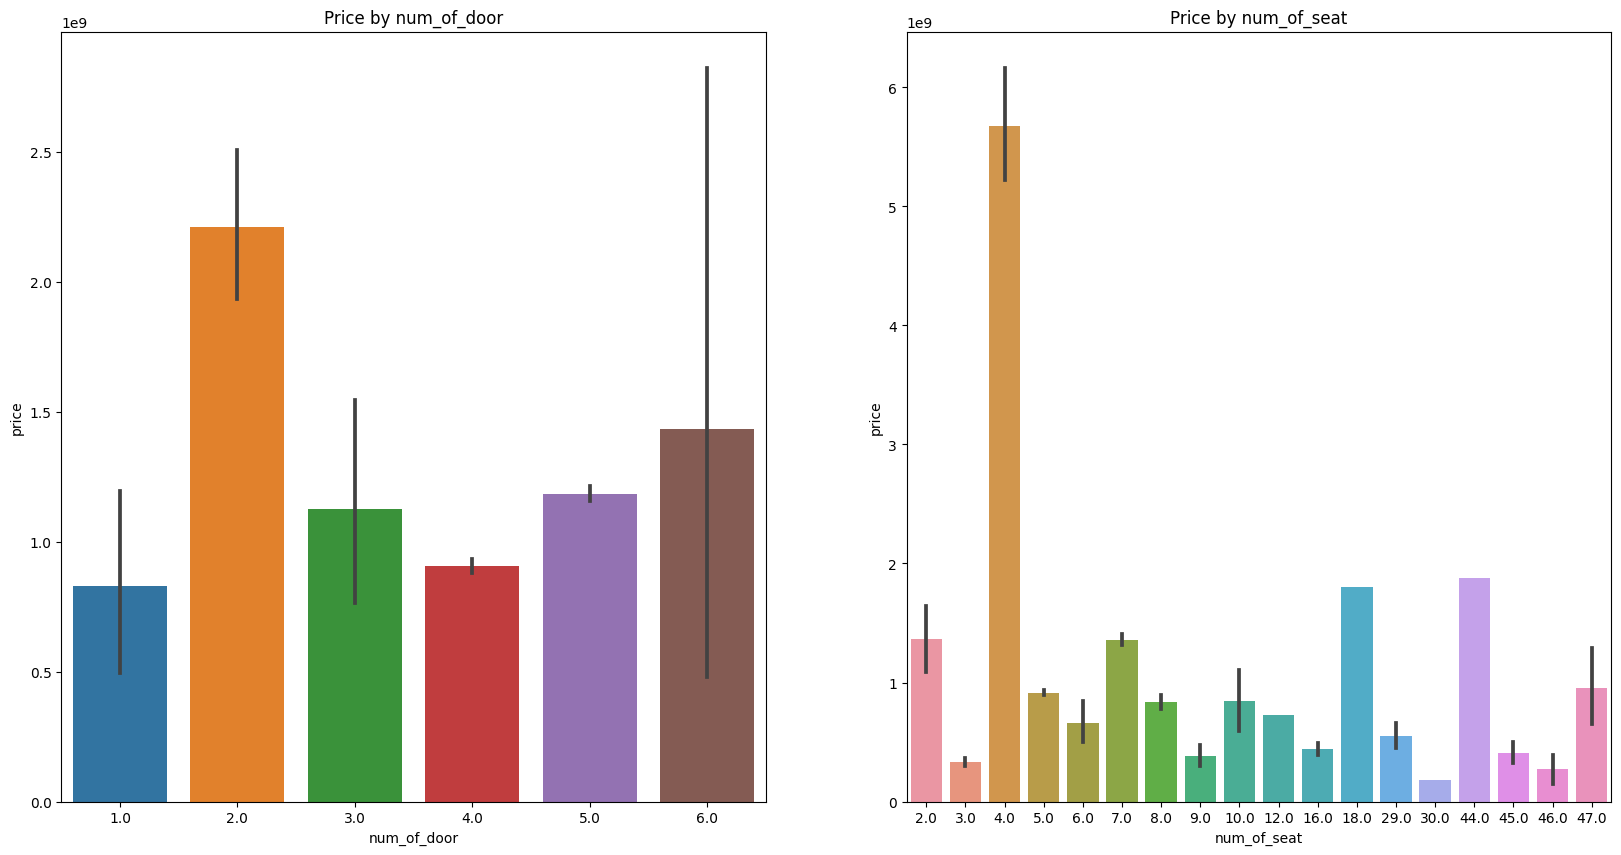

In [304]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.barplot(x='num_of_door', y='price', data=df)
plt.title('Price by num_of_door')
plt.subplot(1, 2, 2)
sns.barplot(x='num_of_seat', y='price', data=df)
plt.title('Price by num_of_seat')
plt.show()

# Tìm hiểu về mối liên hệ giữa các thuộc tính với nhau

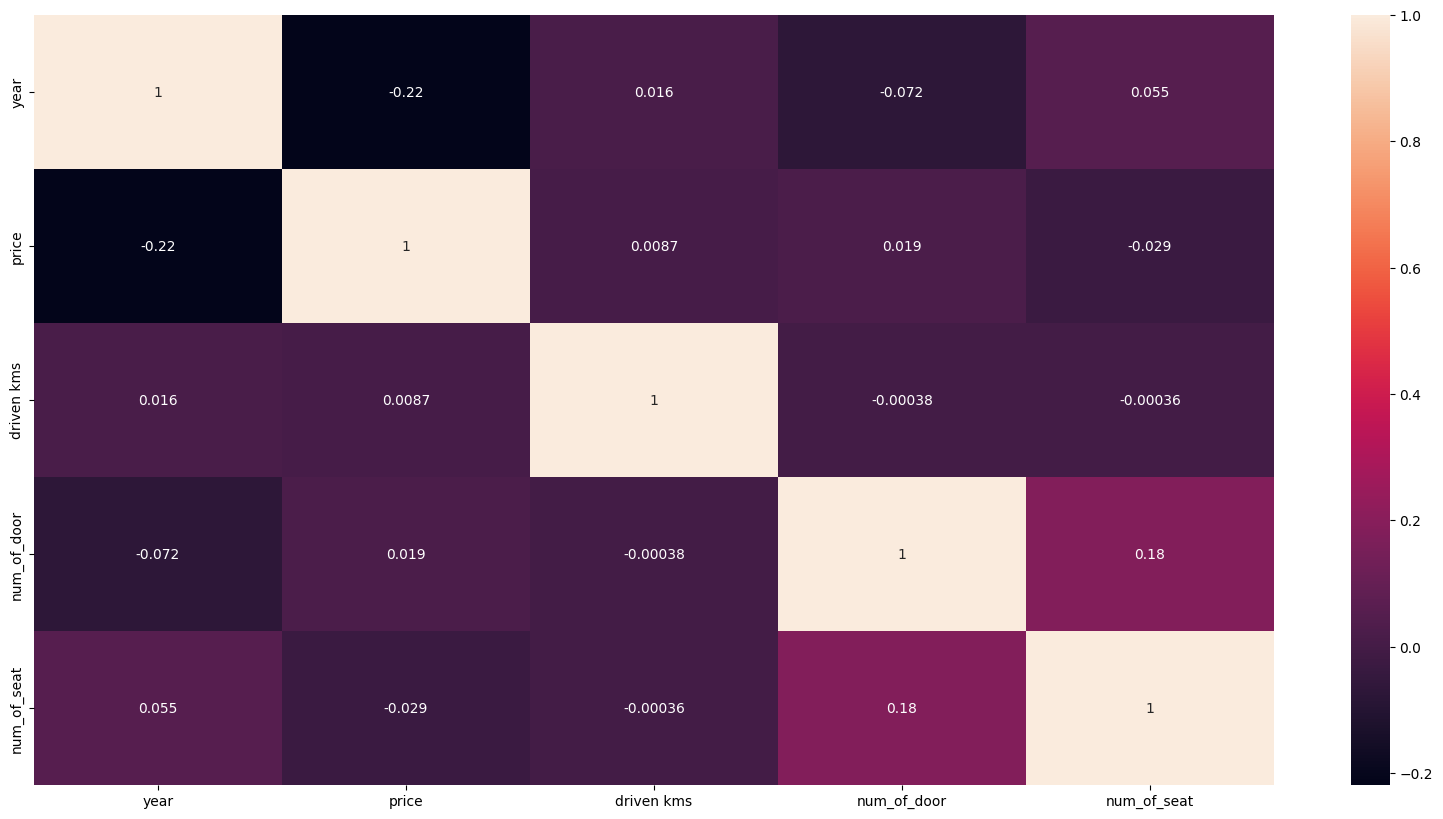

In [305]:
#vẽ biểu đồ nhiệt giữa price và các thuộc tính trừ model
plt.figure(figsize=(20, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()



# Mã hóa các cột dạng nhãn thành dạng số để có thể sử dụng cho mô hình học máy

Cột assemble_place chỉ có 2 giá trị là 'Lắp ráp trong nước' và 'Nhập khẩu', ta sẽ mã hóa thành 0 và 1

In [306]:
df['assemble_place'] = df['assemble_place'].map({'Lắp ráp trong nước': 0, 'Nhập khẩu': 1})

Tương tự cho cột transmission

In [307]:
df['transmission'] = df['transmission'].map({'Số tay': 0, 'Số tự động': 1})

In [308]:
df.columns

Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url',
       'brand', 'model'],
      dtype='object')

In [309]:
df['assemble_place'].value_counts()

assemble_place
0    14551
1    10263
Name: count, dtype: int64

Cột brand sẽ được mã hóa bằng phương pháp One-hot encoding

In [310]:
one_hot = OneHotEncoder()
# one_hot.fit(df[['engine_type','series','model','brand_segment']])
one_hot.fit(df[['engine_type','series','model','brand']])


OneHotEncoder()

In [311]:
column_trans=make_column_transformer((OneHotEncoder(categories=one_hot.categories_),['engine_type','series','model','brand']),
                                    remainder='passthrough')

# Sử dụng Standardization để chuẩn hóa dữ liệu

In [312]:
scaler = StandardScaler()
#fit year và driven kms
scaler.fit(df[['driven kms','num_of_seat']])
df[['driven kms','num_of_seat']] = scaler.transform(df[['driven kms','num_of_seat']])

In [313]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,url,brand,model
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,-0.013821,5.0,-0.316709,Xăng,1.0,https://bonbanh.com/xe-landrover-range_rover-h...,LandRover,Range Rover HSE
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,-0.014292,5.0,0.860377,Xăng,1.0,https://bonbanh.com/xe-mitsubishi-outlander-2....,Mitsubishi,Outlander 2.0 CVT
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,-0.014261,4.0,-0.316709,Xăng,1.0,https://bonbanh.com/xe-mazda-3-1.5l-luxury-201...,Mazda,3 1.5L Luxury
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,-0.014669,4.0,-0.316709,Xăng,1.0,https://bonbanh.com/xe-mazda-2-1.5-at-2015-491...,Mazda,2 1.5 AT
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,-0.015673,5.0,-0.316709,Xăng,1.0,https://bonbanh.com/xe-suzuki-swift-glx-1.2-at...,Suzuki,Swift GLX 1.2


# Sử dụng hồi quy tuyến tính để dự đoán giá xe

In [314]:
df.dropna(inplace=True)

In [315]:
X = df[['engine_type','series','model','brand','year','driven kms','num_of_seat','transmission','assemble_place']]
y = df['price']

In [316]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [317]:
lr=LinearRegression()

In [318]:
pipe=make_pipeline(column_trans,lr)


In [319]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['-', 'Dầu', 'Hybrid', 'Xăng', 'Điện'], dtype=object),
                                                                            array(['Bán tải / Pickup', 'Convertible/Cabriolet', 'Coupe',
       'Crossover', 'Hatchback', 'SUV', 'Sedan', 'Truck', 'Van/Minivan',
       'Wagon'], dtype=object),
                                                                            array(['', '2 1.5 AT',...
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kenbo', 'Kia',
       'Lamborghini', 'LandRover', 'Lexus', 'Lincoln', 'MG', 'Maserati',
       'Mazda', 'McLaren', 'Mercedes', 'Mini', 'Mitsubishi', 'Nissan',
       'Other', 'Peugeot', 'Porsche', 'Renault', 'Rolls', 'Ssangyong',
       'Subaru', 'Suzuki', 'Thaco', 'Toyota', 'VinFast', 'Volkswagen',
       'Volvo'], dtype=object)]),
                                                  ['engine_type', 'series',
                                                   'model', 'brand'])])),
                ('linearregression', LinearRegression())])

In [320]:
y_pred=pipe.predict(X_test)
r2_score(y_test,y_pred)

0.8919680904800891

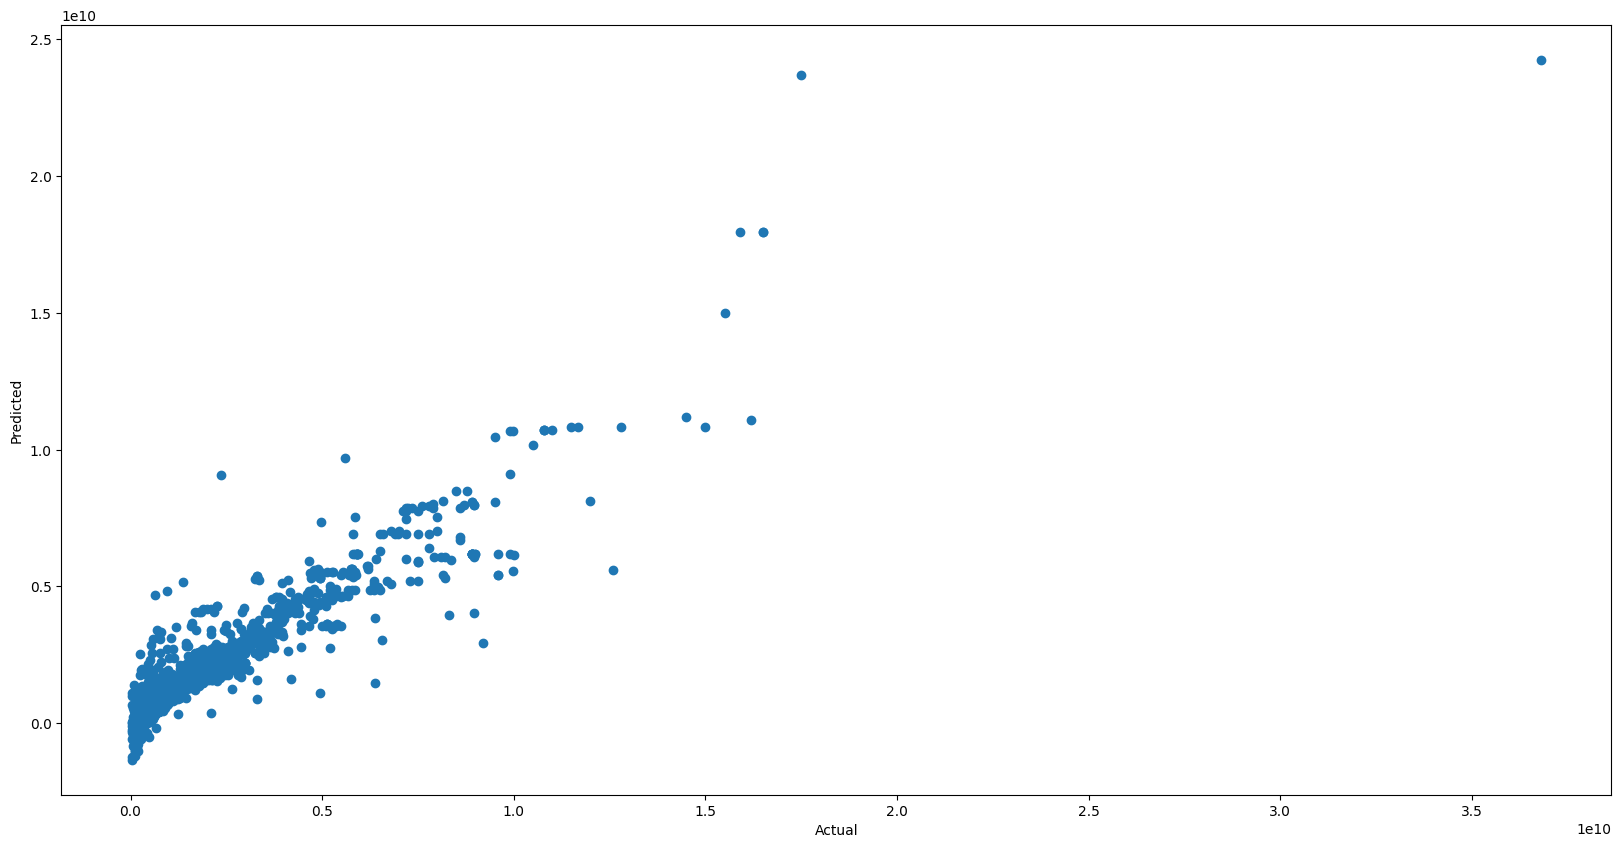

In [321]:
#vẽ biểu đồ phân bố giá trị thực và giá trị dự đoán
plt.figure(figsize=(20, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [322]:
#predict giá xe cho xe có url là https://bonbanh.com/xe-kia-carens-crdi-2.0-at-2008-5020924
car = df[df['url'] == 'https://bonbanh.com/xe-kia-carens-crdi-2.0-at-2008-5020924']
pipe.predict(car[['engine_type','series','model','brand','year','driven kms','num_of_seat','transmission','assemble_place']])

array([2.52725752e+08])

# Random Forest

In [323]:
rf=RandomForestRegressor()
pipe = make_pipeline(column_trans,rf)

In [324]:
from sklearn.model_selection import KFold, RandomizedSearchCV

"""
+ Search over space of hyperparameters to find acceptable ones
+ Two search methods implemented by scikit-learn: GridSearch and RandomSearch
+ RandomSearch is faster in case we search over large space (too many combinations of hyperparameters)
"""

rf_hyperparams = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 50, 90, 110],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_randomized_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = rf_hyperparams,
    n_iter = 10,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs = -1
)



In [325]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['-', 'Dầu', 'Hybrid', 'Xăng', 'Điện'], dtype=object),
                                                                            array(['Bán tải / Pickup', 'Convertible/Cabriolet', 'Coupe',
       'Crossover', 'Hatchback', 'SUV', 'Sedan', 'Truck', 'Van/Minivan',
       'Wagon'], dtype=object),
                                                                            array(['', '2 1.5 AT',...
       'Lamborghini', 'LandRover', 'Lexus', 'Lincoln', 'MG', 'Maserati',
       'Mazda', 'McLaren', 'Mercedes', 'Mini', 'Mitsubishi', 'Nissan',
       'Other', 'Peugeot', 'Porsche', 'Renault', 'Rolls', 'Ssangyong',
       'Subaru', 'Suzuki', 'Thaco', 'Toyota', 'VinFast', 'Volkswagen',
       'Volvo'], dtype=object)]),
                                                  ['engine_type', 'series',
                                                   'model', 'brand'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [326]:
pipe.score(X_test, y_test)

0.9703527880596284

In [ ]:
pickle.dump(pipe,open('RandomeForestModel.pkl','wb'))

In [327]:
pipe.predict(car[['engine_type','series','model','brand','year','driven kms','num_of_seat','transmission','assemble_place']])

array([2.8535e+08])

In [329]:

car =['Xăng','SUV','4 Runner SR5','Toyota',2011,36000,7,'Số tự động','Nhập khẩu']
pipe.predict(pd.DataFrame(columns=['engine_type','series','model','brand','year','driven kms','num_of_seat','transmission','assemble_place'],data=np.array(['Xăng','SUV','Other','Toyota',2011,36000,7,'Số tự động','Nhập khẩu']).reshape(1,9)))

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [ ]:
rf_randomized_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [ ]:
from sklearn.linear_model import Ridge
rg = Ridge(alpha=1.0)
rg.fit(X_train, y_train)
rg.score(X_test, y_test)


0.4294949157635001

In [ ]:
#Support Vector Regression

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

-0.0939616610769054

In [ ]:
df.head()

,year,price,assemble_place,driven kms,num_of_door,num_of_seat,transmission,brand_segment_LOW-PRICE CAR,brand_segment_LUXURY CAR,brand_segment_PREMIUM CAR,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,8.0,2.700000e+09,1,0.379702,5.0,-0.360512,1,False,True,False,...,False,True,False,False,False,False,False,False,True,False
1,5.0,6.660000e+08,0,-0.037590,5.0,1.109346,1,True,False,False,...,False,True,False,False,False,False,False,False,True,False
2,4.0,4.900000e+08,0,-0.009771,4.0,-0.360512,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,8.0,3.650000e+08,0,-0.371425,4.0,-0.360512,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,2.0,5.650000e+08,1,-1.261649,5.0,-0.360512,1,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [ ]:
clf.score(X_test, y_test)